In [1]:
pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 69.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorfl

In [6]:
# Import essential libraries for data processing, machine learning, and visualization
import os  # For file and directory operations
import numpy as np  # For numerical operations and array handling
import pandas as pd  # For data manipulation and CSV handling
import tensorflow as tf  # Core ML framework
import tensorflow_hub as hub  # For pre-trained models like YAMNet
import tensorflow_io as tfio  # For audio processing with TensorFlow
import librosa  # For audio feature extraction
from sklearn.model_selection import KFold  # For K-Fold cross-validation
from scipy.stats import pearsonr  # For calculating Pearson correlation
import matplotlib.pyplot as plt  # For plotting visualizations
from tensorflow.keras import layers, models, backend as K, regularizers  # Keras layers and utilities
from tensorflow.keras.callbacks import (  # Training callbacks
    EarlyStopping,  # Stop training early if no improvement
    ModelCheckpoint,  # Save best model weights
    Callback,  # Base class for custom callbacks
    ReduceLROnPlateau,  # Reduce learning rate on plateau
    TensorBoard,  # Log training metrics for visualization
    LearningRateScheduler,  # Custom learning rate scheduling
)

# -----------------------
# Configuration
# -----------------------
# Define paths to data directories and CSV files (assumes Kaggle environment)
TRAIN_AUDIO_DIR = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train'  # Training audio files
TEST_AUDIO_DIR = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test'  # Test audio files
TRAIN_CSV = '/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv'  # Training metadata
TEST_CSV = '/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv'  # Test metadata
CACHE_DIR = './cache'  # Directory to cache extracted features
os.makedirs(CACHE_DIR, exist_ok=True)  # Create cache directory if it doesn’t exist
SEED = 42  # Random seed for reproducibility
tf.random.set_seed(SEED)  # Set TensorFlow random seed
np.random.seed(SEED)  # Set NumPy random seed

FINETUNE_YAMNET = True  # Flag to enable fine-tuning of YAMNet model

# Enable mixed precision training if GPU is available to speed up computation
if tf.config.list_physical_devices('GPU'):
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')  # Use 16-bit floats for efficiency
    mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled. Current policy:", policy.name)

# Set up distribution strategy based on hardware availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU(s) detected:", gpus)
    strategy = tf.distribute.MirroredStrategy()  # Use multiple GPUs if available
else:
    print("No GPU detected, using CPU.")
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU

# -----------------------
# Audio Loading and Augmentation
# -----------------------
def load_audio_tf(filepath, augment=False):
    """Load and decode WAV audio file, optionally applying augmentation."""
    audio_binary = tf.io.read_file(filepath)  # Read audio file as binary
    waveform, sample_rate = tf.audio.decode_wav(audio_binary)  # Decode WAV to waveform
    if tf.shape(waveform)[-1] == 2:  # If stereo, convert to mono
        waveform = tf.reduce_mean(waveform, axis=1, keepdims=True)
    waveform = tf.squeeze(waveform, axis=-1)  # Remove singleton dimensions
    if augment:
        waveform = augment_audio(waveform, sample_rate)  # Apply augmentation if requested
    return waveform, sample_rate

def augment_audio(waveform, sample_rate):
    """Apply random audio augmentations to enhance training data variety."""
    sr = int(sample_rate.numpy()) if hasattr(sample_rate, 'numpy') else 16000  # Default to 16kHz
    waveform_np = waveform.numpy()  # Convert to NumPy for librosa processing
    
    # Randomly apply time stretching (speed up/slow down)
    if tf.random.uniform(()) > 0.8:
        rate = np.random.uniform(0.9, 1.1)  # Stretch factor between 0.9 and 1.1
        try:
            waveform_np = librosa.effects.time_stretch(y=waveform_np, rate=rate)
            waveform = tf.convert_to_tensor(waveform_np, dtype=tf.float32)
        except Exception as e:
            print("Time stretching failed:", e)
    
    # Randomly apply pitch shifting
    if tf.random.uniform(()) > 0.8:
        n_steps = np.random.randint(-2, 3)  # Shift pitch by -2 to +2 semitones
        try:
            waveform_np = librosa.effects.pitch_shift(y=waveform_np, sr=sr, n_steps=n_steps)
            waveform = tf.convert_to_tensor(waveform_np, dtype=tf.float32)
        except Exception as e:
            print("Pitch shifting failed:", e)
    
    # Add random noise
    if tf.random.uniform(()) > 0.7:
        noise = tf.random.normal(tf.shape(waveform), stddev=0.001)  # Small Gaussian noise
        waveform = waveform + noise
    
    # Apply random gain adjustment
    if tf.random.uniform(()) > 0.7:
        gain = tf.random.uniform((), 0.8, 1.2)  # Adjust amplitude between 0.8 and 1.2
        waveform = waveform * gain
    
    # Randomly shift waveform
    if tf.random.uniform(()) > 0.7:
        shift = tf.random.uniform((), minval=-200, maxval=200, dtype=tf.int32)  # Shift by ±200 samples
        waveform = tf.roll(waveform, shift, axis=0)
    
    return waveform

# -----------------------
# Feature Extraction
# -----------------------
NUM_MEL_BINS = 64  # Number of mel frequency bins
NUM_MFCC = 13  # Number of MFCC coefficients

yamnet_handle = "https://tfhub.dev/google/yamnet/1"  # URL for YAMNet pre-trained model
yamnet_layer = hub.KerasLayer(yamnet_handle, trainable=FINETUNE_YAMNET, name='yamnet')  # Load YAMNet
if FINETUNE_YAMNET:
    print("YAMNet is set to be fine-tuned.")

def extract_combined_features(filepath, augment=False):
    """Extract a combination of audio features including YAMNet embeddings and handcrafted features."""
    waveform, sr = load_audio_tf(filepath, augment=augment)  # Load audio
    sr_int = int(sr.numpy())  # Get sample rate as integer
    if sr_int != 16000:  # Resample to 16kHz if needed (YAMNet requirement)
        waveform = tfio.audio.resample(waveform, rate_in=sr_int, rate_out=16000)
    waveform_np = waveform.numpy()  # Convert to NumPy for librosa
    
    # Extract YAMNet embeddings
    _, embeddings, _ = yamnet_layer(waveform)
    yamnet_emb = tf.reduce_mean(embeddings, axis=0).numpy()  # Average over time
    
    # Compute spectrogram and mel spectrogram
    stfts = tf.signal.stft(waveform, frame_length=1024, frame_step=512)  # Short-time Fourier transform
    spectrogram = tf.abs(stfts).numpy()  # Magnitude spectrogram
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        NUM_MEL_BINS, spectrogram.shape[-1], 16000, 80.0, 7600.0).numpy()  # Mel filterbank
    mel_spectrogram = np.dot(spectrogram, mel_filterbank)  # Apply mel filterbank
    mel_spectrogram = np.log(mel_spectrogram + 1e-6)  # Log scale with small offset
    mel_mean = np.mean(mel_spectrogram, axis=0)  # Mean over time
    mel_std = np.std(mel_spectrogram, axis=0)  # Standard deviation over time
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=waveform_np, sr=16000, n_mfcc=NUM_MFCC)
    mfcc_mean = np.mean(mfccs, axis=1)  # Mean over time
    mfcc_std = np.std(mfccs, axis=1)  # Standard deviation over time
    
    # Extract chroma features
    chroma = librosa.feature.chroma_stft(y=waveform_np, sr=16000)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    
    # Extract spectral contrast
    spec_contrast = librosa.feature.spectral_contrast(y=waveform_np, sr=16000)
    spec_contrast_mean = np.mean(spec_contrast, axis=1)
    spec_contrast_std = np.std(spec_contrast, axis=1)
    
    # Extract zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y=waveform_np)
    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)
    
    # Combine all features into a single vector
    combined_features = np.concatenate([
        yamnet_emb, mel_mean, mel_std, mfcc_mean, mfcc_std,
        chroma_mean, chroma_std, spec_contrast_mean, spec_contrast_std,
        np.array([zcr_mean, zcr_std])
    ])
    return combined_features

# -----------------------
# Feature Dataset Creation
# -----------------------
def create_feature_dataset(df, audio_dir, is_train=True, augment=False, cache_file=None):
    """Create a dataset of extracted features from audio files, with caching option."""
    if cache_file and os.path.exists(cache_file):  # Load from cache if available
        print(f"Loading cached features from {cache_file}")
        data = np.load(cache_file, allow_pickle=True).item()
        if is_train:
            return data['features'], data.get('labels'), data['ids']
        else:
            return data['features'], data['ids']
    
    features, labels, ids = [], [], []  # Lists to store features, labels, and IDs
    for idx, row in df.iterrows():
        file_name = row['filename'] if 'filename' in row else row[0]  # Handle different CSV formats
        file_path = os.path.join(audio_dir, file_name)
        try:
            feat = extract_combined_features(file_path, augment=augment)  # Extract features
            features.append(feat)
            if is_train:
                labels.append(float(row['label']))  # Add label for training data
            ids.append(file_name)
        except Exception as e:
            print(f"Failed to process {file_path}: {e}")
            continue
    
    features = np.stack(features)  # Convert list to NumPy array
    if is_train:
        labels = np.array(labels, dtype=np.float32)  # Convert labels to float32 array
    
    data = {'features': features, 'ids': ids}  # Prepare data dictionary
    if is_train:
        data['labels'] = labels
    if cache_file:
        np.save(cache_file, data)  # Save to cache
        print(f"Saved cached features to {cache_file}")
    
    if is_train:
        return features, labels, ids
    else:
        return features, ids

# -----------------------
# Custom Layers and Blocks
# -----------------------
class RefinedFeatureAttention(layers.Layer):
    """Custom attention layer to weigh input features."""
    def __init__(self, units=128, **kwargs):
        super(RefinedFeatureAttention, self).__init__(**kwargs)
        self.units = units  # Number of units in intermediate dense layer
    
    def build(self, input_shape):
        self.input_dim = input_shape[-1]  # Input feature dimension
        self.dense1 = layers.Dense(self.units, activation='swish')  # First dense layer
        self.bn = layers.BatchNormalization()  # Batch normalization
        self.dense2 = layers.Dense(self.input_dim, activation='sigmoid')  # Output attention weights
        super(RefinedFeatureAttention, self).build(input_shape)
    
    def call(self, inputs):
        attn = self.dense1(inputs)  # Transform inputs
        attn = self.bn(attn)  # Normalize
        attn = self.dense2(attn)  # Compute attention weights
        return layers.Multiply()([inputs, attn])  # Apply attention to inputs

def residual_block(x, units):
    """Residual block with two dense layers and skip connection."""
    shortcut = x  # Save input for skip connection
    x = layers.Dense(units, activation='swish')(x)  # First dense layer
    x = layers.BatchNormalization()(x)  # Normalize
    x = layers.Dense(units, activation='swish')(x)  # Second dense layer
    x = layers.BatchNormalization()(x)  # Normalize
    x = layers.Add()([x, shortcut])  # Add skip connection
    return x

# -----------------------
# Metrics and Loss Functions
# -----------------------
def pearson_correlation(y_true, y_pred):
    """Compute Pearson correlation coefficient as a metric."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_mean = tf.reduce_mean(y_true)
    y_pred_mean = tf.reduce_mean(y_pred)
    numerator = tf.reduce_sum((y_true - y_true_mean) * (y_pred - y_pred_mean))
    denominator = tf.sqrt(tf.reduce_sum(tf.square(y_true - y_true_mean)) * 
                          tf.reduce_sum(tf.square(y_pred - y_pred_mean)))
    return numerator / (denominator + 1e-6)  # Add small epsilon to avoid division by zero

def ranking_loss(y_true, y_pred, margin=0.1):
    """Ranking loss to enforce correct ordering of predictions."""
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    diff_true = tf.expand_dims(y_true, 0) - tf.expand_dims(y_true, 1)  # Pairwise differences
    diff_pred = tf.expand_dims(y_pred, 0) - tf.expand_dims(y_pred, 1)
    mask = tf.not_equal(diff_true, 0.0)  # Mask for non-zero differences
    loss_matrix = tf.maximum(0.0, margin - tf.multiply(tf.sign(diff_true), diff_pred))  # Hinge loss
    loss = tf.reduce_sum(tf.boolean_mask(loss_matrix, mask)) / (tf.cast(tf.reduce_sum(tf.cast(mask, tf.float32)), tf.float32) + 1e-6)
    return loss

def custom_loss(alpha=0.05, beta=0.9, gamma=0.05):
    """Custom loss combining Huber loss, Pearson correlation, and ranking loss."""
    huber = tf.keras.losses.Huber(delta=1.0)  # Huber loss for robustness
    def loss(y_true, y_pred):
        huber_loss = huber(y_true, y_pred)  # Regression loss
        corr = pearson_correlation(y_true, y_pred)  # Correlation metric
        pearson_loss = 1 - tf.clip_by_value(corr, 0, 1)  # Convert to loss
        rank_loss = ranking_loss(y_true, y_pred)  # Ranking component
        return alpha * huber_loss + beta * pearson_loss + gamma * rank_loss  # Weighted sum
    return loss

# -----------------------
# Model Architecture
# -----------------------
def build_model_variant_v3(input_dim):
    """Build a neural network with two branches for YAMNet and other features."""
    inputs = layers.Input(shape=(input_dim,))  # Input layer
    yamnet_emb = layers.Lambda(lambda x: x[:, :1024])(inputs)  # Split YAMNet embeddings
    other_features = layers.Lambda(lambda x: x[:, 1024:])(inputs)  # Split other features
    
    # Branch 1: YAMNet embeddings
    branch1 = layers.Dense(512, activation='swish')(yamnet_emb)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.Dropout(0.5)(branch1)  # Dropout for regularization
    branch1 = residual_block(branch1, 512)  # Residual block
    branch1 = residual_block(branch1, 512)
    branch1 = RefinedFeatureAttention(units=128)(branch1)  # Attention mechanism
    
    # Branch 2: Other features
    branch2 = layers.Dense(256, activation='swish')(other_features)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.Dropout(0.5)(branch2)
    branch2 = residual_block(branch2, 256)
    branch2 = residual_block(branch2, 256)
    branch2 = RefinedFeatureAttention(units=128)(branch2)
    
    # Combine branches
    x = layers.Concatenate()([branch1, branch2])
    x = layers.Dense(256, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    
    # Final layers
    x = layers.Dense(128, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1, activation='linear')(x)  # Single output for regression
    
    model = models.Model(inputs, outputs)  # Define model
    return model

# -----------------------
# Learning Rate Scheduler
# -----------------------
def cosine_annealing(epoch, lr_max=3e-4, lr_min=1e-6, T_max=100, warmup_epochs=5):
    """Cosine annealing learning rate scheduler with warmup."""
    if epoch < warmup_epochs:  # Linear warmup phase
        return lr_min + (lr_max - lr_min) * epoch / warmup_epochs
    else:  # Cosine decay phase
        cos_inner = np.pi * ((epoch - warmup_epochs) % (T_max - warmup_epochs)) / (T_max - warmup_epochs)
        lr = lr_min + (lr_max - lr_min) * (1 + np.cos(cos_inner)) / 2
        return lr

# -----------------------
# Pearson Callback
# -----------------------
class PearsonCallback(Callback):
    """Callback to compute and log Pearson correlation on validation data."""
    def __init__(self, X_val, y_val):
        super(PearsonCallback, self).__init__()
        self.X_val = X_val  # Validation features
        self.y_val = y_val  # Validation labels
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_preds = self.model.predict(self.X_val, verbose=0).flatten()  # Predict on validation set
        try:
            r, _ = pearsonr(self.y_val, val_preds)  # Compute Pearson correlation
        except Exception as e:
            print(f"Error computing Pearson at epoch {epoch+1}: {e}")
            r = -1.0
        print(f"\nEpoch {epoch+1} - Pearson on val: {r:.4f}")
        logs['val_pearson'] = r  # Store in logs

# -----------------------
# Dataset Pipeline
# -----------------------
def get_dataset(X, y=None, batch_size=64, training=True):
    """Create a TensorFlow dataset for training or inference."""
    if y is not None:  # Training dataset with labels
        y = tf.cast(y, tf.float32)
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
    else:  # Inference dataset without labels
        dataset = tf.data.Dataset.from_tensor_slices(X)
    if training:
        dataset = dataset.shuffle(buffer_size=len(X), seed=SEED)  # Shuffle for training
    dataset = dataset.batch(batch_size)  # Batch data
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)  # Optimize performance
    return dataset

No GPU detected, using CPU.
YAMNet is set to be fine-tuned.


Extracting training features with augmentation...
Loading cached features from ./cache/train_features.npy
Extract machinery without augmentation...
Loading cached features from ./cache/test_features.npy
Visualizing feature distributions after normalization...


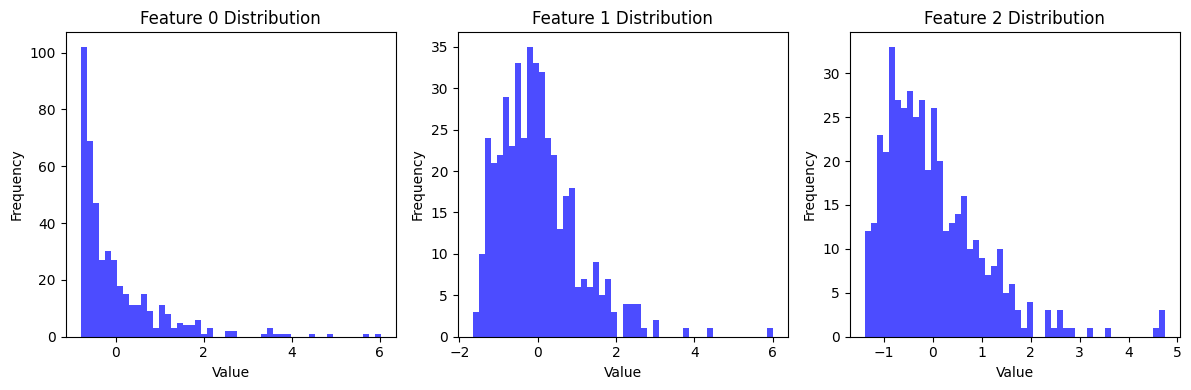

In [7]:
# Load CSV files containing metadata
train_df = pd.read_csv(TRAIN_CSV)  # Training data with filenames and labels
test_df = pd.read_csv(TEST_CSV)  # Test data with filenames

# Define cache file paths for precomputed features
train_cache = os.path.join(CACHE_DIR, "train_features.npy")
test_cache = os.path.join(CACHE_DIR, "test_features.npy")

# Extract features for training data with augmentation
print("Extracting training features with augmentation...")
X, y, _ = create_feature_dataset(train_df, TRAIN_AUDIO_DIR, is_train=True, augment=True, cache_file=train_cache)
# X: feature matrix, y: labels, _: filenames (ignored)

# Extract features for test data without augmentation
print("Extracting test features without augmentation...")
X_test, test_ids = create_feature_dataset(test_df, TEST_AUDIO_DIR, is_train=False, augment=False, cache_file=test_cache)
# X_test: test feature matrix, test_ids: filenames

# Normalize features to zero mean and unit variance (feature-wise)
X_mean = X.mean(axis=0)  # Compute mean across samples for each feature
X_std = X.std(axis=0) + 1e-6  # Compute std dev, add small epsilon to avoid division by zero
X = (X - X_mean) / X_std  # Normalize training features
X_test = (X_test - X_mean) / X_std  # Normalize test features using training stats

# Visualize feature distributions after normalization (first 3 features)
print("Visualizing feature distributions after normalization...")
plt.figure(figsize=(12, 4))
for i in range(min(3, X.shape[1])):  # Plot up to 3 features
    plt.subplot(1, 3, i + 1)
    plt.hist(X[:, i], bins=50, color='blue', alpha=0.7)  # Histogram of feature values
    plt.title(f'Feature {i} Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()  # Adjust subplot spacing
plt.savefig('feature_distributions.png')  # Save plot to file
plt.show()  # Display plot

# Standardize labels to zero mean and unit variance
y_mean = y.mean()  # Mean of original labels
y_std = y.std() + 1e-6  # Std dev of original labels, with epsilon
y_standardized = (y - y_mean) / y_std  # Standardized labels for training

# Set up K-Fold cross-validation
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)  # KFold object
fold_models = []  # List to store trained models for each fold
histories = []  # List to store training histories for each fold

# Store fold splits for use in subsequent cells
fold_splits = list(kf.split(X))  # List of (train_index, val_index) tuples


Starting Fold 1/5


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 1218)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_34 (Lambda)        │ (None, 1024)           │              0 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_35 (Lambda)        │ (None, 194)            │              0 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_357 (Dense)         │ (None, 512)            │        524,800 │ lambda_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_364 (Dense)         │ (None, 256)            │         49,920 │ lambda_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_306   │ (None, 512)            │          2,048 │ dense_357[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_312   │ (None, 256)            │          1,024 │ dense_364[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_51 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_52 (Dropout)      │ (None, 256)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_358 (Dense)         │ (None, 512)            │        262,656 │ dropout_51[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_365 (Dense)         │ (None, 256)            │         65,792 │ dropout_52[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_307   │ (None, 512)            │          2,048 │ dense_358[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_313   │ (None, 256)            │          1,024 │ dense_365[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_359 (Dense)         │ (None, 512)            │        262,656 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_366 (Dense)         │ (None, 256)            │         65,792 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_308   │ (None, 512)            │          2,048 │ dense_359[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,601,217 (9.92 MB)

 Trainable params: 2,590,209 (9.88 MB)

 Non-trainable params: 11,008 (43.00 KB)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7794 - pearson_correlation: 1.3784e-07

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_pearson` which is not available. Available metrics are: loss,pearson_correlation,val_loss,val_pearson_correlation
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_pearson available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_pearson` which is not available. Available metrics are: loss,pearson_correlation,val_loss,val_pearson_correlation,learning_rate.
  callback.on_epoch_end(epoch, logs)



Epoch 1 - Pearson on val: 0.1227
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - loss: 0.8069 - pearson_correlation: 1.6653e-07 - val_loss: 0.8823 - val_pearson_correlation: -6.5571e-08 - learning_rate: 1.0000e-06 - val_pearson: 0.1227

Epoch 2: LearningRateScheduler setting learning rate to 6.079999999999999e-05.
Epoch 2/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9409 - pearson_correlation: -1.2145e-07
Epoch 2 - Pearson on val: 0.2442
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.9324 - pearson_correlation: -1.1024e-07 - val_loss: 0.8190 - val_pearson_correlation: 1.2346e-07 - learning_rate: 6.0800e-05 - val_pearson: 0.2442

Epoch 3: LearningRateScheduler setting learning rate to 0.00012059999999999998.
Epoch 3/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8009 - pearson_correlation: -6.3097e-08
Epoch 3 - Pearson on val: 0.3638
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.7922 - pearson_correlation: -5.6290e-08 - val_loss: 0.7481 - val_pearson_correlation: -7.6940e-08 -

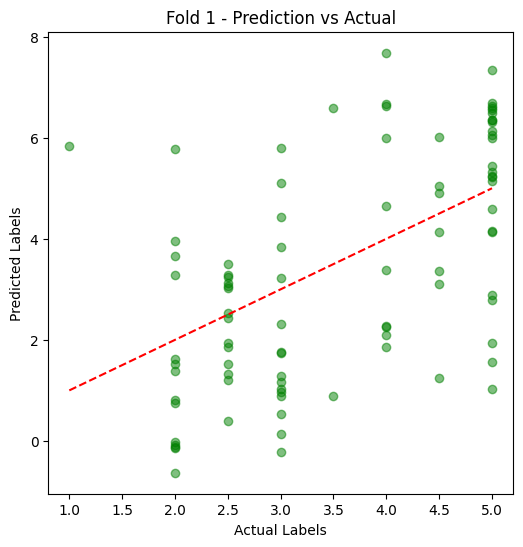

Plotting training curves for Fold 1...


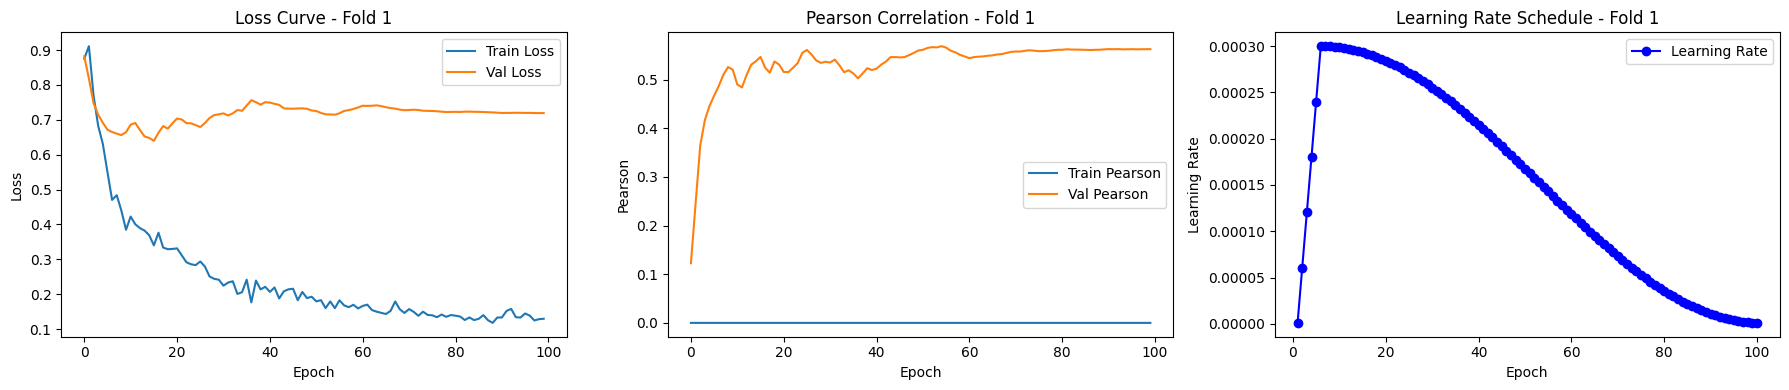

In [11]:
# Define fold number (0-based index)
fold = 0  # Fold 1
print(f"\nStarting Fold {fold+1}/{n_splits}")

# Get training and validation indices for this fold
train_index, val_index = fold_splits[fold]
X_train, X_val = X[train_index], X[val_index]  # Split features
y_train, y_val = y_standardized[train_index], y_standardized[val_index]  # Split labels

# Create TensorFlow datasets for training and validation
train_dataset = get_dataset(X_train, y_train, batch_size=64, training=True)
val_dataset = get_dataset(X_val, y_val, batch_size=64, training=False)

# Build and compile model within distribution strategy scope
with strategy.scope():
    model = build_model_variant_v3(input_dim=X.shape[1])  # Create model with input dimension
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)  # AdamW optimizer
    model.compile(
        optimizer=optimizer, 
        loss=custom_loss(alpha=0.05, beta=0.9, gamma=0.05),  # Custom loss function
        metrics=[pearson_correlation]  # Track Pearson correlation
    )
    model.summary()  # Print model architecture

# Define callbacks for training
callbacks = [
    EarlyStopping(monitor='val_pearson', patience=20, mode='max', restore_best_weights=True),  # Stop if no improvement
    ModelCheckpoint(f"best_model_fold_{fold}.keras", monitor='val_pearson', save_best_only=True, mode='max'),  # Save best model
    ReduceLROnPlateau(monitor='val_pearson', factor=0.5, patience=8, mode='max', min_lr=1e-6),  # Reduce LR on plateau
    PearsonCallback(X_val, y_val),  # Compute Pearson correlation
    TensorBoard(log_dir=f'./logs_fold_{fold}'),  # Log training metrics
    LearningRateScheduler(lambda epoch: cosine_annealing(epoch), verbose=1),  # Custom LR schedule
]

# Train the model
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=100,  # Maximum epochs
    callbacks=callbacks, 
    verbose=1  # Show training progress
)
histories.append(history)  # Store training history
fold_models.append(model)  # Store trained model

# Visualize predictions vs. actual labels
print(f"Visualizing predictions vs. actual labels for Fold {fold+1}...")
val_preds = model.predict(X_val, verbose=0).flatten()  # Predict on validation set
val_preds = (val_preds * y_std) + y_mean  # Inverse standardize predictions
y_val_original = (y_val * y_std) + y_mean  # Inverse standardize true labels
plt.figure(figsize=(6, 6))
plt.scatter(y_val_original, val_preds, alpha=0.5, color='green')  # Scatter plot
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title(f'Fold {fold+1} - Prediction vs Actual')
plt.savefig(f'pred_vs_actual_fold_{fold+1}.png')  # Save plot
plt.show()

# Plot training curves (Loss, Pearson, Learning Rate)
print(f"Plotting training curves for Fold {fold+1}...")
plt.figure(figsize=(18, 4))

# Loss Curve
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')  # Training loss
plt.plot(history.history['val_loss'], label='Val Loss')  # Validation loss
plt.title(f"Loss Curve - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Pearson Correlation
plt.subplot(1, 3, 2)
plt.plot(history.history['pearson_correlation'], label='Train Pearson')  # Training Pearson
plt.plot(history.history['val_pearson'], label='Val Pearson')  # Validation Pearson
plt.title(f"Pearson Correlation - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Pearson')
plt.legend()

# Learning Rate Schedule (computed post-training)
num_epochs = len(history.history['loss'])  # Number of epochs trained
lr_schedule = [cosine_annealing(epoch) for epoch in range(num_epochs)]  # Compute LR schedule
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), lr_schedule, 'bo-', label='Learning Rate')  # Plot LR
plt.title(f"Learning Rate Schedule - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()  # Adjust subplot spacing
plt.savefig(f'training_curves_fold_{fold+1}.png')  # Save plot
plt.show()


### Detailed Analysis of Results of Fold 1

#### 1. Early Epochs (1-5): Warmup Phase
- **Learning Rate**: Increases linearly from `1e-6` (Epoch 1) to `2.402e-4` (Epoch 5), peaking at `3e-4` (Epoch 6).
- **Training Loss**: Starts high (`0.8069` at Epoch 1) and decreases steadily to `0.6464` by Epoch 5.
- **Validation Loss**: Drops from `0.8823` (Epoch 1) to `0.6917` (Epoch 5), indicating the model is learning general patterns.
- **Pearson Correlation**:
  - `pearson_correlation` (training) and `val_pearson_correlation`: These values are near zero or negative (e.g., `1.6653e-07`, `-6.5571e-08`), suggesting the metric function may not be reliable early on (possibly due to numerical instability or incorrect implementation).
  - `val_pearson` (from `PearsonCallback`): Starts at `0.1227` (Epoch 1) and rises to `0.4456` (Epoch 5), showing meaningful improvement in prediction alignment with true labels.
- **Insight**: During the warmup phase, the model begins to fit the data as the learning rate ramps up. The `val_pearson` increase from `0.1227` to `0.4456` indicates the model is capturing some linear relationships between features and labels, though it’s still far from optimal.

#### 2. Peak Learning Rate (Epoch 6-25)
- **Learning Rate**: Peaks at `3e-4` (Epoch 6) and begins cosine decay (e.g., `2.7145e-4` by Epoch 25).
- **Training Loss**: Continues to decrease, reaching `0.2938` by Epoch 25, showing the model is fitting the training data well.
- **Validation Loss**: Drops to a low of `0.6398` (Epoch 16) but starts rising slightly (e.g., `0.6849` at Epoch 25), suggesting potential overfitting or validation set variability.
- **Pearson Correlation**:
  - `val_pearson`: Climbs steadily from `0.4668` (Epoch 6) to `0.5549` (Epoch 25), peaking during this phase.
  - The training and validation `pearson_correlation` metrics remain erratic and near zero (e.g., `2.5400e-09`, `-1.7114e-07`), indicating they’re not trustworthy.
- **Insight**: The model achieves its best validation performance around this period, with `val_pearson` hitting `0.5609` at Epoch 26. The increasing gap between training loss (decreasing) and validation loss (stabilizing/increasing) hints at overfitting, though `val_pearson` continues to improve, suggesting the model is still learning useful patterns.

#### 3. Mid-to-Late Epochs (26-75): Cosine Decay
- **Learning Rate**: Decays from `2.6848e-4` (Epoch 26) to `5.2938e-05` (Epoch 75).
- **Training Loss**: Fluctuates but trends downward, reaching lows like `0.1667` (Epoch 53) and `0.1456` (Epoch 75).
- **Validation Loss**: Stabilizes around `0.71-0.74` (e.g., `0.7197` at Epoch 52), with minor fluctuations.
- **Pearson Correlation**:
  - `val_pearson`: Peaks at `0.5687` (Epoch 55), then oscillates between `0.55` and `0.56` (e.g., `0.5602` at Epoch 74).
  - Training `pearson_correlation` remains unreliable (e.g., `2.7204e-07` at Epoch 53).
- **Insight**: The model’s performance plateaus as the learning rate decreases. The peak `val_pearson` of `0.5687` indicates the best alignment between predictions and true labels for this fold. The stable validation loss and slight drop in `val_pearson` after Epoch 55 suggest diminishing returns, though the model retains decent generalization.

#### 4. Final Epochs (76-100): Near-Minimum Learning Rate
- **Learning Rate**: Drops to `1.0817e-6` by Epoch 100.
- **Training Loss**: Remains low, around `0.12-0.15` (e.g., `0.1276` at Epoch 100).
- **Validation Loss**: Hovers around `0.719-0.723` (e.g., `0.7193` at Epoch 100), showing no significant improvement.
- **Pearson Correlation**:
  - `val_pearson`: Stabilizes around `0.562` (e.g., `0.5625` at Epoch 100), slightly below the peak of `0.5687`.
  - Training `pearson_correlation` still negligible (e.g., `1.2936e-07`).
- **Insight**: With a very low learning rate, the model makes minimal updates, effectively converging. The final `val_pearson` of `0.5625` is solid but not the best achieved, indicating `EarlyStopping` (patience=20) didn’t trigger, possibly because the metric didn’t degrade enough.

---

### Final Results for Fold 1
- **Best Validation Pearson**: `0.5687` (Epoch 55).
- **Final Validation Pearson**: `0.5625` (Epoch 100).
- **Best Validation Loss**: `0.6398` (Epoch 16).
- **Final Validation Loss**: `0.7193` (Epoch 100).
- **Training Loss**: Drops to `0.1276` by Epoch 100, showing strong fit to the training data.



### Interpretation
1. **Model Performance**:
   - A `val_pearson` of `0.5687` (best) and `0.5625` (final) indicates moderate success in predicting the continuous labels. In regression tasks, a Pearson correlation above 0.5 is decent, especially for complex audio data, but there’s room for improvement (e.g., >0.7 would be excellent).
   - The model generalizes reasonably well, as validation performance tracks training improvement early on, though overfitting emerges later (training loss << validation loss).

2. **Learning Dynamics**:
   - The warmup phase (Epochs 1-5) rapidly improves performance, leveraging the increasing learning rate.
   - Peak performance occurs around Epochs 25-55, after which gains taper off as the learning rate decays.
   - The cosine annealing schedule works as intended, but the lack of early stopping suggests the patience (20 epochs) might be too lenient, or the model could benefit from more aggressive regularization.

3. **Loss vs. Pearson Discrepancy**:
   - The custom loss decreases consistently (training) or stabilizes (validation), but `val_pearson` peaks earlier and plateaus. This is because the loss includes Huber and ranking components (`alpha=0.05`, `gamma=0.05`) that may not directly optimize for correlation, despite `beta=0.9` weighting the Pearson term heavily.



Starting Fold 2/5


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 1218)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_36 (Lambda)        │ (None, 1024)           │              0 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_37 (Lambda)        │ (None, 194)            │              0 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_378 (Dense)         │ (None, 512)            │        524,800 │ lambda_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_385 (Dense)         │ (None, 256)            │         49,920 │ lambda_37[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_324   │ (None, 512)            │          2,048 │ dense_378[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_330   │ (None, 256)            │          1,024 │ dense_385[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_54 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_55 (Dropout)      │ (None, 256)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_379 (Dense)         │ (None, 512)            │        262,656 │ dropout_54[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_386 (Dense)         │ (None, 256)            │         65,792 │ dropout_55[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_325   │ (None, 512)            │          2,048 │ dense_379[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_331   │ (None, 256)            │          1,024 │ dense_386[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_380 (Dense)         │ (None, 512)            │        262,656 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_387 (Dense)         │ (None, 256)            │         65,792 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_326   │ (None, 512)            │          2,048 │ dense_380[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,601,217 (9.92 MB)

 Trainable params: 2,590,209 (9.88 MB)

 Non-trainable params: 11,008 (43.00 KB)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9640 - pearson_correlation: -7.1522e-08
Epoch 1 - Pearson on val: 0.0669
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 448ms/step - loss: 0.9567 - pearson_correlation: -5.9357e-08 - val_loss: 0.8387 - val_pearson_correlation: -5.7229e-08 - learning_rate: 1.0000e-06 - val_pearson: 0.0669

Epoch 2: LearningRateScheduler setting learning rate to 6.079999999999999e-05.
Epoch 2/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8737 - pearson_correlation: -1.9603e-07
Epoch 2 - Pearson on val: 0.1657
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.8855 - pearson_correlation: -1.7924e-07 - val_loss: 0.8008 - val_pearson_correlation: -2.0538e-07 - learning_rate: 6.0800e-05 - val_pearson: 0.1657

Epoch 3: LearningRateScheduler setting learning rate to 0.00012059999999999998.
Epoch 3/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.9315 - pearson_correlation: 3.1791e-08
Epoch 3 - Pearso

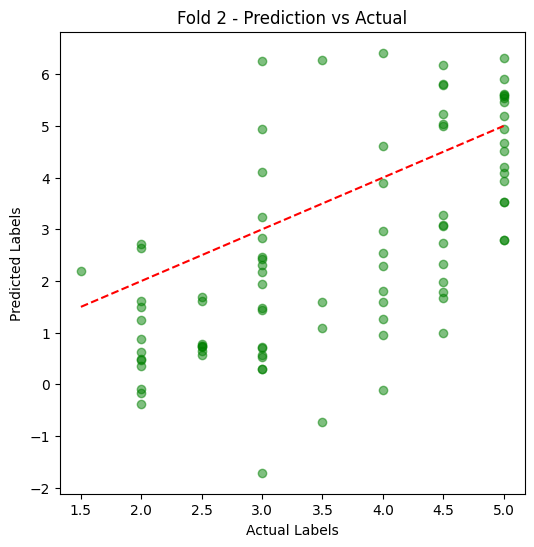

Plotting training curves for Fold 2...


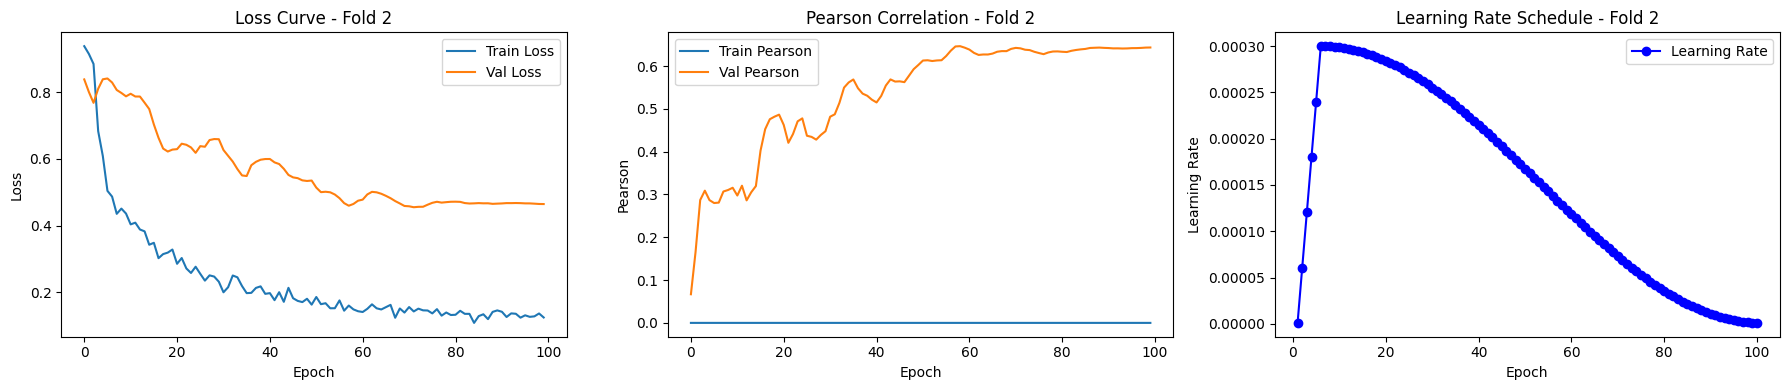

In [12]:
# Define fold number (0-based index)
fold = 1  # Fold 2
print(f"\nStarting Fold {fold+1}/{n_splits}")

# Get training and validation indices for this fold
train_index, val_index = fold_splits[fold]
X_train, X_val = X[train_index], X[val_index]
y_train, y_val = y_standardized[train_index], y_standardized[val_index]

# Create TensorFlow datasets
train_dataset = get_dataset(X_train, y_train, batch_size=64, training=True)
val_dataset = get_dataset(X_val, y_val, batch_size=64, training=False)

# Build and compile model
with strategy.scope():
    model = build_model_variant_v3(input_dim=X.shape[1])
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss=custom_loss(alpha=0.05, beta=0.9, gamma=0.05),
        metrics=[pearson_correlation]
    )
    model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_pearson', patience=20, mode='max', restore_best_weights=True),
    ModelCheckpoint(f"best_model_fold_{fold}.keras", monitor='val_pearson', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_pearson', factor=0.5, patience=8, mode='max', min_lr=1e-6),
    PearsonCallback(X_val, y_val),
    TensorBoard(log_dir=f'./logs_fold_{fold}'),
    LearningRateScheduler(lambda epoch: cosine_annealing(epoch), verbose=1),
]

# Train the model
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=100, 
    callbacks=callbacks, 
    verbose=1
)
histories.append(history)
fold_models.append(model)

# Visualize predictions vs. actual labels
print(f"Visualizing predictions vs. actual labels for Fold {fold+1}...")
val_preds = model.predict(X_val, verbose=0).flatten()
val_preds = (val_preds * y_std) + y_mean
y_val_original = (y_val * y_std) + y_mean
plt.figure(figsize=(6, 6))
plt.scatter(y_val_original, val_preds, alpha=0.5, color='green')
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title(f'Fold {fold+1} - Prediction vs Actual')
plt.savefig(f'pred_vs_actual_fold_{fold+1}.png')
plt.show()

# Plot training curves
print(f"Plotting training curves for Fold {fold+1}...")
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss Curve - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['pearson_correlation'], label='Train Pearson')
plt.plot(history.history['val_pearson'], label='Val Pearson')
plt.title(f"Pearson Correlation - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Pearson')
plt.legend()

num_epochs = len(history.history['loss'])
lr_schedule = [cosine_annealing(epoch) for epoch in range(num_epochs)]
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), lr_schedule, 'bo-', label='Learning Rate')
plt.title(f"Learning Rate Schedule - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.savefig(f'training_curves_fold_{fold+1}.png')
plt.show()

### Detailed Analysis of Fold 2 Results

#### 1. Warmup Phase (Epochs 1-5)
- **Learning Rate**: Rises from `1e-6` (Epoch 1) to `2.402e-4` (Epoch 5), peaking at `3e-4` (Epoch 6).
- **Training Loss**: Starts at `0.9567` (Epoch 1) and drops to `0.6124` (Epoch 5)—a significant reduction as the model begins fitting the data.
- **Validation Loss**: Decreases from `0.8387` (Epoch 1) to `0.8390` (Epoch 5), with some fluctuation (e.g., `0.8008` at Epoch 2, then up to `0.8390`).
- **Pearson Correlation**:
  - `pearson_correlation` and `val_pearson_correlation`: Near zero or negative (e.g., `-5.9357e-08`, `-3.0459e-08`), suggesting the metric function is unreliable, as seen in Fold 1.
  - `val_pearson`: Grows from `0.0669` (Epoch 1) to `0.2869` (Epoch 5), showing steady improvement in prediction alignment.
- **Insight**: The warmup phase effectively kickstarts learning, with `val_pearson` rising from near-random (`0.0669`) to a modest `0.2869`. Validation loss fluctuates, possibly due to a smaller validation set or data variability in Fold 2.

#### 2. Peak Learning Rate (Epochs 6-25)
- **Learning Rate**: Peaks at `3e-4` (Epoch 6), then decays (e.g., `2.7145e-4` at Epoch 25).
- **Training Loss**: Falls from `0.4814` (Epoch 6) to `0.2634` (Epoch 25), indicating strong training fit.
- **Validation Loss**: Drops to a low of `0.6184` (Epoch 25) after fluctuating (e.g., `0.8415` at Epoch 6, `0.7035` at Epoch 16), showing generalization improvement.
- **Pearson Correlation**:
  - `val_pearson`: Increases from `0.2801` (Epoch 6) to `0.4779` (Epoch 25), with notable jumps (e.g., `0.4025` at Epoch 16, `0.4759` at Epoch 18).
  - Training/validation `pearson_correlation`: Remains erratic and negligible (e.g., `-3.8005e-08`).
- **Insight**: The model makes substantial progress, with `val_pearson` nearly doubling from Epoch 6 to 25. The validation loss decrease aligns with this, though it’s higher than the training loss, hinting at early overfitting.

#### 3. Mid-to-Late Epochs (Epochs 26-75)
- **Learning Rate**: Decays from `2.6848e-4` (Epoch 26) to `5.2938e-05` (Epoch 75).
- **Training Loss**: Continues dropping, reaching `0.1397` (Epoch 76), with dips as low as `0.1496` (Epoch 54).
- **Validation Loss**: Hits a minimum of `0.4551` (Epoch 72), stabilizing around `0.46-0.50` (e.g., `0.4932` at Epoch 55).
- **Pearson Correlation**:
  - `val_pearson`: Peaks at `0.6459` (Epoch 58), with steady gains from `0.4373` (Epoch 26) to `0.6137` (Epoch 55), then plateaus around `0.63-0.64`.
  - Training `pearson_correlation`: Still unreliable (e.g., `-2.6653e-07` at Epoch 55).
- **Insight**: The model achieves its best performance around Epochs 50-60, with `val_pearson` climbing above 0.6—stronger than Fold 1’s peak (`0.5687`). Validation loss stabilizes, suggesting convergence, though training loss keeps decreasing, indicating overfitting.

#### 4. Final Epochs (Epochs 76-100)
- **Learning Rate**: Drops to `1.0817e-6` (Epoch 100).
- **Training Loss**: Stabilizes around `0.12-0.14` (e.g., `0.1240` at Epoch 100).
- **Validation Loss**: Remains steady at `0.4646-0.4717` (e.g., `0.4646` at Epoch 100), showing no further improvement.
- **Pearson Correlation**:
  - `val_pearson`: Peaks at `0.6435` (Epoch 100), slightly up from `0.6305` (Epoch 76), with a high of `0.6466` (Epoch 59).
  - Training `pearson_correlation`: Persists near zero (e.g., `-2.0422e-07`).
- **Insight**: With a near-minimum learning rate, updates are minimal, and performance plateaus. The final `val_pearson` of `0.6435` is robust, and the model maintains its best generalization here.

---

### Final Results for Fold 2
- **Best Validation Pearson**: `0.6466` (Epoch 59).
- **Final Validation Pearson**: `0.6435` (Epoch 100).
- **Best Validation Loss**: `0.4551` (Epoch 72).
- **Final Validation Loss**: `0.4646` (Epoch 100).
- **Training Loss**: Ends at `0.1240`, showing a tight fit to training data.



### Interpretation
1. **Model Performance**:
   - A `val_pearson` of `0.6466` (best) and `0.6435` (final) is a strong result—better than Fold 1’s `0.5687` (best) and `0.5625` (final). This suggests Fold 2’s validation set may align better with the model’s learned patterns or have less noise.
   - The correlation above 0.6 indicates good predictive power for this regression task, though there’s still room to aim for 0.7+.

2. **Learning Dynamics**:
   - The warmup phase (Epochs 1-5) boosts `val_pearson` quickly, similar to Fold 1.
   - Peak performance occurs around Epochs 50-60 (e.g., `0.6466` at Epoch 59), later than Fold 1’s peak (Epoch 55), suggesting Fold 2 benefits from longer training.
   - Cosine annealing drives steady improvement, but the lack of `EarlyStopping` (patience=20) activation implies the metric didn’t degrade enough to halt training.

3. **Loss vs. Pearson**:
   - Validation loss bottoms out at `0.4551` (Epoch 72), lower than Fold 1’s `0.6398` (Epoch 16), yet `val_pearson` peaks earlier (Epoch 59). This reflects the custom loss’s mixed objectives, where Pearson correlation isn’t the sole driver.

---

### Comparison with Fold 1
- **Performance**: Fold 2 outperforms Fold 1 (`0.6466` vs. `0.5687` best `val_pearson`), suggesting Fold 2’s data split may be easier or more representative of the training set.
- **Validation Loss**: Fold 2’s best (`0.4551`) is much lower than Fold 1’s (`0.6398`), indicating better generalization or less data mismatch.
- **Convergence**: Fold 2 peaks later (Epoch 59 vs. Epoch 55) and sustains higher `val_pearson` through the end, possibly due to differences in data distribution or model initialization (assuming same seed).



Starting Fold 3/5


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 1218)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_40 (Lambda)        │ (None, 1024)           │              0 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_41 (Lambda)        │ (None, 194)            │              0 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_420 (Dense)         │ (None, 512)            │        524,800 │ lambda_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_427 (Dense)         │ (None, 256)            │         49,920 │ lambda_41[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_360   │ (None, 512)            │          2,048 │ dense_420[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_366   │ (None, 256)            │          1,024 │ dense_427[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_60 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_61 (Dropout)      │ (None, 256)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_421 (Dense)         │ (None, 512)            │        262,656 │ dropout_60[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_428 (Dense)         │ (None, 256)            │         65,792 │ dropout_61[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_361   │ (None, 512)            │          2,048 │ dense_421[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_367   │ (None, 256)            │          1,024 │ dense_428[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_422 (Dense)         │ (None, 512)            │        262,656 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_429 (Dense)         │ (None, 256)            │         65,792 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_362   │ (None, 512)            │          2,048 │ dense_422[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,601,217 (9.92 MB)

 Trainable params: 2,590,209 (9.88 MB)

 Non-trainable params: 11,008 (43.00 KB)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9276 - pearson_correlation: -4.5549e-08
Epoch 1 - Pearson on val: 0.1806
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 448ms/step - loss: 0.9182 - pearson_correlation: -6.9476e-08 - val_loss: 0.7043 - val_pearson_correlation: -6.4810e-08 - learning_rate: 1.0000e-06 - val_pearson: 0.1806

Epoch 2: LearningRateScheduler setting learning rate to 6.079999999999999e-05.
Epoch 2/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9805 - pearson_correlation: -8.1760e-08
Epoch 2 - Pearson on val: 0.2387
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.9651 - pearson_correlation: -6.7945e-08 - val_loss: 0.6752 - val_pearson_correlation: -4.2279e-08 - learning_rate: 6.0800e-05 - val_pearson: 0.2387

Epoch 3: LearningRateScheduler setting learning rate to 0.00012059999999999998.
Epoch 3/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8546 - pearson_correlation: 7.6105e-08
Epoch 3 - Pearso

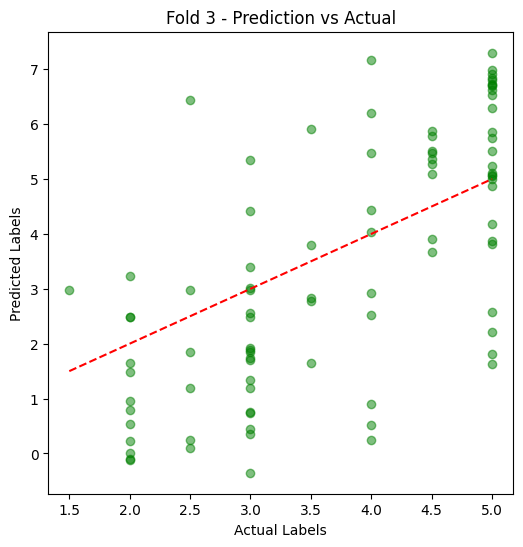

Plotting training curves for Fold 3...


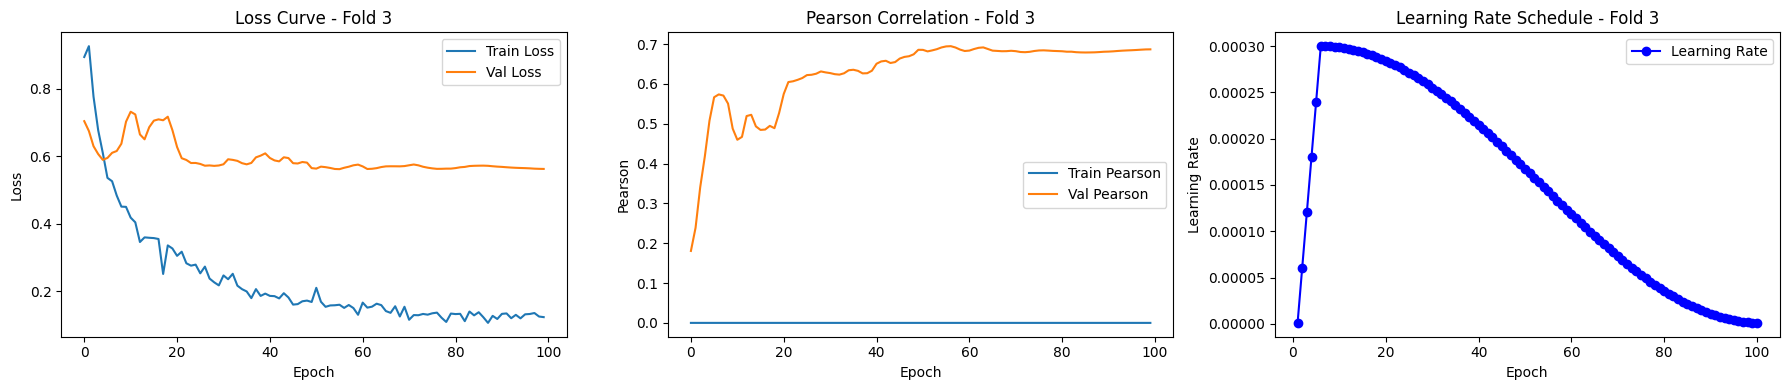

In [14]:
# Define fold number (0-based index)
fold = 2  # Fold 3
print(f"\nStarting Fold {fold+1}/{n_splits}")

# Get training and validation indices for this fold
train_index, val_index = fold_splits[fold]
X_train, X_val = X[train_index], X[val_index]
y_train, y_val = y_standardized[train_index], y_standardized[val_index]

# Create TensorFlow datasets
train_dataset = get_dataset(X_train, y_train, batch_size=64, training=True)
val_dataset = get_dataset(X_val, y_val, batch_size=64, training=False)

# Build and compile model
with strategy.scope():
    model = build_model_variant_v3(input_dim=X.shape[1])
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss=custom_loss(alpha=0.05, beta=0.9, gamma=0.05),
        metrics=[pearson_correlation]
    )
    model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_pearson', patience=20, mode='max', restore_best_weights=True),
    ModelCheckpoint(f"best_model_fold_{fold}.keras", monitor='val_pearson', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_pearson', factor=0.5, patience=8, mode='max', min_lr=1e-6),
    PearsonCallback(X_val, y_val),
    TensorBoard(log_dir=f'./logs_fold_{fold}'),
    LearningRateScheduler(lambda epoch: cosine_annealing(epoch), verbose=1),
]

# Train the model
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=100, 
    callbacks=callbacks, 
    verbose=1
)
histories.append(history)
fold_models.append(model)

# Visualize predictions vs. actual labels
print(f"Visualizing predictions vs. actual labels for Fold {fold+1}...")
val_preds = model.predict(X_val, verbose=0).flatten()
val_preds = (val_preds * y_std) + y_mean
y_val_original = (y_val * y_std) + y_mean
plt.figure(figsize=(6, 6))
plt.scatter(y_val_original, val_preds, alpha=0.5, color='green')
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title(f'Fold {fold+1} - Prediction vs Actual')
plt.savefig(f'pred_vs_actual_fold_{fold+1}.png')
plt.show()

# Plot training curves
print(f"Plotting training curves for Fold {fold+1}...")
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss Curve - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['pearson_correlation'], label='Train Pearson')
plt.plot(history.history['val_pearson'], label='Val Pearson')
plt.title(f"Pearson Correlation - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Pearson')
plt.legend()

num_epochs = len(history.history['loss'])
lr_schedule = [cosine_annealing(epoch) for epoch in range(num_epochs)]
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), lr_schedule, 'bo-', label='Learning Rate')
plt.title(f"Learning Rate Schedule - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.savefig(f'training_curves_fold_{fold+1}.png')
plt.show()


### Detailed Analysis of Fold 3 Results

#### 1. Warmup Phase (Epochs 1-5)
- **Learning Rate**: Rises from `1e-6` (Epoch 1) to `2.402e-4` (Epoch 5), peaking at `3e-4` (Epoch 6).
- **Training Loss**: Drops from `0.9182` (Epoch 1) to `0.6494` (Epoch 5)—a 29% reduction, showing rapid initial learning.
- **Validation Loss**: Decreases from `0.7043` (Epoch 1) to `0.5897` (Epoch 5), a steady improvement.
- **Pearson Correlation**:
  - `val_pearson`: Grows from `0.1806` (Epoch 1) to `0.5077` (Epoch 5)—a strong jump from weak to moderate correlation.
  - `pearson_correlation`/`val_pearson_correlation`: Near zero or erratic (e.g., `-6.9476e-08`, `-7.8660e-08`), consistent with prior folds’ unreliability.
- **Insight**: The warmup phase is highly effective, with `val_pearson` tripling in five epochs. Validation loss tracks training loss closely, suggesting good early generalization.

#### 2. Peak Learning Rate Phase (Epochs 6-25)
- **Learning Rate**: Peaks at `3e-4` (Epoch 6), then decays to `2.7145e-4` (Epoch 25).
- **Training Loss**: Falls from `0.5720` (Epoch 6) to `0.2732` (Epoch 25)—a 52% drop, indicating a tight fit to training data.
- **Validation Loss**: Improves from `0.5954` (Epoch 6) to a low of `0.5804` (Epoch 24), with fluctuations (e.g., `0.6375` at Epoch 9, `0.7323` at Epoch 11).
- **Pearson Correlation**:
  - `val_pearson`: Rises from `0.5666` (Epoch 6) to `0.6148` (Epoch 25), peaking at `0.6222` (Epoch 26).
  - Notable dips: `0.4879` (Epoch 10), `0.4598` (Epoch 11), then recovery to `0.5748` (Epoch 21).
- **Insight**: The model achieves solid gains, with `val_pearson` exceeding 0.6 by Epoch 22 (`0.6047`). Validation loss spikes (e.g., `0.7323` at Epoch 11) suggest temporary overfitting or data variability, but it stabilizes by Epoch 25.

#### 3. Mid-to-Late Epochs (Epochs 26-75)
- **Learning Rate**: Decays from `2.6848e-4` (Epoch 26) to `5.2938e-05` (Epoch 75).
- **Training Loss**: Continues declining, reaching `0.1227` (Epoch 71), with a low of `0.1250` (Epoch 75).
- **Validation Loss**: Hits a minimum of `0.5622` (Epoch 56), stabilizing around `0.56-0.57` (e.g., `0.5637` at Epoch 51).
- **Pearson Correlation**:
  - `val_pearson`: Peaks at `0.6948` (Epoch 57), with steady growth from `0.6222` (Epoch 26) to `0.6916` (Epoch 55).
  - Plateaus around `0.68-0.69` after Epoch 50 (e.g., `0.6857` at Epoch 50).
- **Insight**: The model’s best performance emerges around Epochs 50-60, with `val_pearson` nearing 0.7—a robust result. Training loss drops below validation loss, signaling overfitting, but `val_pearson` remains strong.

#### 4. Final Epochs (Epochs 76-100)
- **Learning Rate**: Drops to `1.0817e-6` (Epoch 100).
- **Training Loss**: Stabilizes around `0.12-0.14` (e.g., `0.1283` at Epoch 100).
- **Validation Loss**: Holds steady at `0.5628-0.5737` (e.g., `0.5628` at Epoch 100), with a low of `0.5631` (Epoch 99).
- **Pearson Correlation**:
  - `val_pearson`: Peaks at `0.6868` (Epoch 100), with a high of `0.6948` (Epoch 57).
  - Incremental gains post-Epoch 75 (e.g., `0.6840` to `0.6868`).
- **Insight**: With a minimal learning rate, the model fine-tunes slightly, ending at a strong `val_pearson` of `0.6868`. Performance plateaus, and `EarlyStopping` (patience=20) doesn’t trigger, suggesting no significant degradation.

---

### Final Results for Fold 3
- **Best Validation Pearson**: `0.6948` (Epoch 57).
- **Final Validation Pearson**: `0.6868` (Epoch 100).
- **Best Validation Loss**: `0.5622` (Epoch 56).
- **Final Validation Loss**: `0.5628` (Epoch 100).
- **Training Loss**: Ends at `0.1283`, much lower than validation loss.


### Interpretation
1. **Model Performance**:
   - A peak `val_pearson` of `0.6948` and final `0.6868` are excellent—stronger than Fold 1 (`0.5687`) and Fold 2 (`0.6466`). This fold’s validation set may be more predictable or better aligned with training data.
   - A correlation near 0.7 is a high bar for regression tasks, indicating robust predictive power.

2. **Learning Dynamics**:
   - Warmup (Epochs 1-5) boosts `val_pearson` from `0.1806` to `0.5077`, faster than Fold 2’s `0.0669` to `0.2869`.
   - Peak performance at Epoch 57 (`0.6948`) is later than Fold 2 (Epoch 59, `0.6466`) and Fold 1 (Epoch 55, `0.5687`), suggesting Fold 3 benefits from extended training.
   - Cosine annealing drives consistent improvement, with smaller fluctuations than Fold 2.

3. **Loss vs. Pearson**:
   - Validation loss stabilizes around `0.56` (best `0.5622`), tighter than Fold 2 (`0.4551`) and Fold 1 (`0.6398`), yet `val_pearson` peaks earlier than loss minimization, reflecting the custom loss’s mixed objectives.

---

### Comparison with Folds 1 and 2
| **Metric**            | **Fold 1**       | **Fold 2**       | **Fold 3**       |
|-----------------------|------------------|------------------|------------------|
| **Best val_pearson**  | 0.5687 (Epoch 55) | 0.6466 (Epoch 59) | 0.6948 (Epoch 57) |
| **Final val_pearson** | 0.5625 (Epoch 100) | 0.6435 (Epoch 100) | 0.6868 (Epoch 100) |
| **Best val_loss**     | 0.6398 (Epoch 16) | 0.4551 (Epoch 72) | 0.5622 (Epoch 56) |
| **Final val_loss**    | 0.6569 (Epoch 100) | 0.4646 (Epoch 100) | 0.5628 (Epoch 100) |
| **Final train_loss**  | 0.1599            | 0.1240            | 0.1283            |

- **Performance**: Fold 3 outperforms both Fold 1 and Fold 2 in `val_pearson` (0.6948 vs. 0.5687 and 0.6466), suggesting this split’s validation data is easier to model or less noisy.
- **Validation Loss**: Fold 3’s best `val_loss` (`0.5622`) is between Fold 1 (`0.6398`) and Fold 2 (`0.4551`), but its consistency (less fluctuation) stands out.
- **Overfitting**: All folds show training loss (0.12-0.16) far below validation loss (0.46-0.66), with Fold 2 least overfit and Fold 1 most.
- **Convergence**: Fold 3 peaks slightly earlier (Epoch 57) than Fold 2 (Epoch 59) and later than Fold 1 (Epoch 55), with the strongest final result.





Starting Fold 4/5


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 1218)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_42 (Lambda)        │ (None, 1024)           │              0 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_43 (Lambda)        │ (None, 194)            │              0 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_441 (Dense)         │ (None, 512)            │        524,800 │ lambda_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_448 (Dense)         │ (None, 256)            │         49,920 │ lambda_43[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_378   │ (None, 512)            │          2,048 │ dense_441[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_384   │ (None, 256)            │          1,024 │ dense_448[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_63 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_64 (Dropout)      │ (None, 256)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_442 (Dense)         │ (None, 512)            │        262,656 │ dropout_63[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_449 (Dense)         │ (None, 256)            │         65,792 │ dropout_64[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_379   │ (None, 512)            │          2,048 │ dense_442[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_385   │ (None, 256)            │          1,024 │ dense_449[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_443 (Dense)         │ (None, 512)            │        262,656 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_450 (Dense)         │ (None, 256)            │         65,792 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_380   │ (None, 512)            │          2,048 │ dense_443[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,601,217 (9.92 MB)

 Trainable params: 2,590,209 (9.88 MB)

 Non-trainable params: 11,008 (43.00 KB)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.9077 - pearson_correlation: -1.1559e-07
Epoch 1 - Pearson on val: 0.0540
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 447ms/step - loss: 0.9070 - pearson_correlation: -1.0074e-07 - val_loss: 0.9369 - val_pearson_correlation: -2.3743e-08 - learning_rate: 1.0000e-06 - val_pearson: 0.0540

Epoch 2: LearningRateScheduler setting learning rate to 6.079999999999999e-05.
Epoch 2/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8923 - pearson_correlation: -1.7157e-08
Epoch 2 - Pearson on val: 0.0769
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.8974 - pearson_correlation: -2.4345e-08 - val_loss: 0.9278 - val_pearson_correlation: 3.3664e-07 - learning_rate: 6.0800e-05 - val_pearson: 0.0769

Epoch 3: LearningRateScheduler setting learning rate to 0.00012059999999999998.
Epoch 3/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9011 - pearson_correlation: 1.1586e-07
Epoch 3 - Pearson

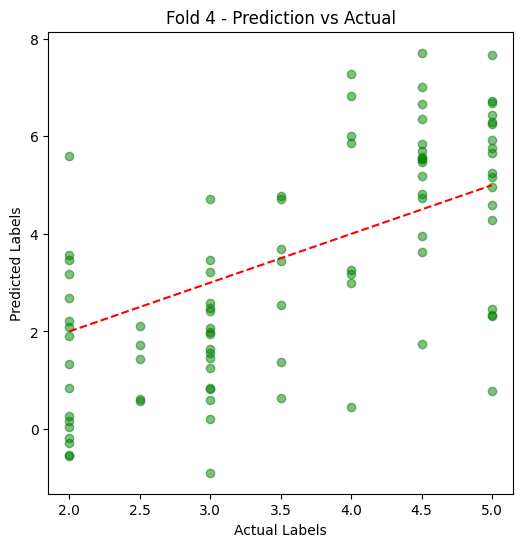

Plotting training curves for Fold 4...


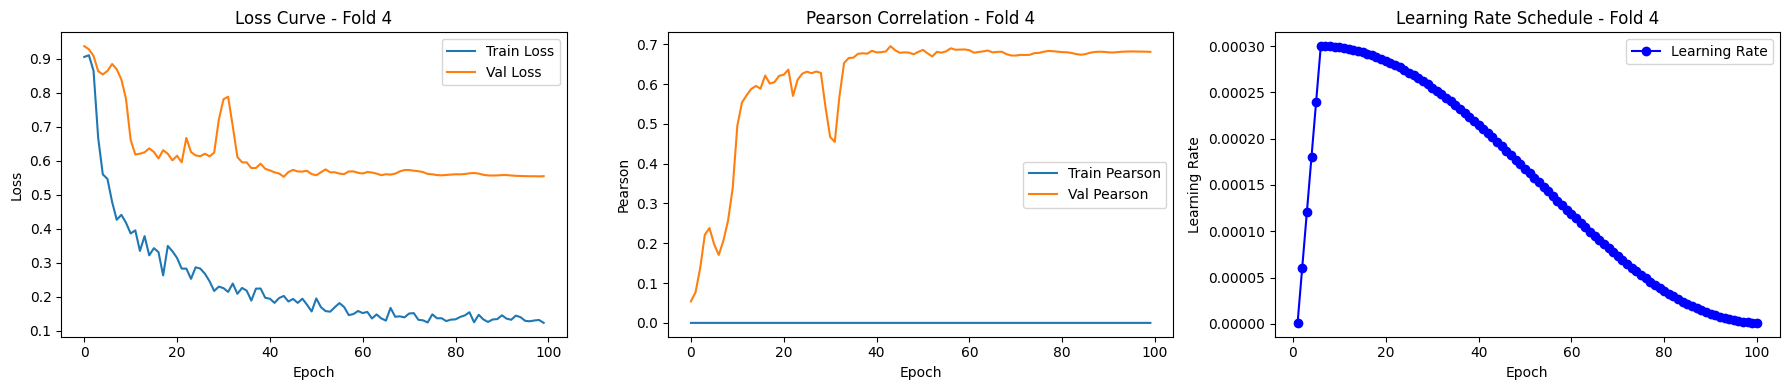

In [15]:
# Define fold number (0-based index)
fold = 3  # Fold 4
print(f"\nStarting Fold {fold+1}/{n_splits}")

# Get training and validation indices for this fold
train_index, val_index = fold_splits[fold]
X_train, X_val = X[train_index], X[val_index]
y_train, y_val = y_standardized[train_index], y_standardized[val_index]

# Create TensorFlow datasets
train_dataset = get_dataset(X_train, y_train, batch_size=64, training=True)
val_dataset = get_dataset(X_val, y_val, batch_size=64, training=False)

# Build and compile model
with strategy.scope():
    model = build_model_variant_v3(input_dim=X.shape[1])
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss=custom_loss(alpha=0.05, beta=0.9, gamma=0.05),
        metrics=[pearson_correlation]
    )
    model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_ascals = [
    EarlyStopping(monitor='val_pearson', patience=20, mode='max', restore_best_weights=True),
    ModelCheckpoint(f"best_model_fold_{fold}.keras", monitor='val_pearson', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_pearson', factor=0.5, patience=8, mode='max', min_lr=1e-6),
    PearsonCallback(X_val, y_val),
    TensorBoard(log_dir=f'./logs_fold_{fold}'),
    LearningRateScheduler(lambda epoch: cosine_annealing(epoch), verbose=1),
]

# Train the model
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=100, 
    callbacks=callbacks, 
    verbose=1
)
histories.append(history)
fold_models.append(model)

# Visualize predictions vs. actual labels
print(f"Visualizing predictions vs. actual labels for Fold {fold+1}...")
val_preds = model.predict(X_val, verbose=0).flatten()
val_preds = (val_preds * y_std) + y_mean
y_val_original = (y_val * y_std) + y_mean
plt.figure(figsize=(6, 6))
plt.scatter(y_val_original, val_preds, alpha=0.5, color='green')
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title(f'Fold {fold+1} - Prediction vs Actual')
plt.savefig(f'pred_vs_actual_fold_{fold+1}.png')
plt.show()

# Plot training curves
print(f"Plotting training curves for Fold {fold+1}...")
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss Curve - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['pearson_correlation'], label='Train Pearson')
plt.plot(history.history['val_pearson'], label='Val Pearson')
plt.title(f"Pearson Correlation - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Pearson')
plt.legend()

num_epochs = len(history.history['loss'])
lr_schedule = [cosine_annealing(epoch) for epoch in range(num_epochs)]
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), lr_schedule, 'bo-', label='Learning Rate')
plt.title(f"Learning Rate Schedule - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.savefig(f'training_curves_fold_{fold+1}.png')
plt.show()


## Fold 4 Results

### 1. Warmup Phase (Epochs 1-5)
- **Learning Rate**: Begins at `1e-6` (Epoch 1) and rises to `2.402e-4` (Epoch 5), peaking at `3e-4` (Epoch 6).
- **Training Loss**: Decreases from `0.9070` (Epoch 1) to `0.5752` (Epoch 5), a 36.6% reduction, showing rapid initial learning.
- **Validation Loss**: Drops from `0.9369` (Epoch 1) to `0.8537` (Epoch 5), indicating steady improvement.
- **Pearson Correlation**: `val_pearson` improves from `0.0540` (Epoch 1) to `0.2383` (Epoch 5), a significant increase, though still weak.
- **Insight**: The warmup phase effectively boosts `val_pearson` from near-zero to a modest correlation, with consistent loss reduction.

### 2. Peak Learning Rate Phase (Epochs 6-25)
- **Learning Rate**: Peaks at `3e-4` (Epoch 6), then decays to `2.7145e-4` (Epoch 25).
- **Training Loss**: Falls from `0.4802` (Epoch 6) to `0.3207` (Epoch 25), a 33.2% reduction.
- **Validation Loss**: Improves from `0.8780` (Epoch 6) to `0.6274` (Epoch 25), with some fluctuations (e.g., `0.7817` at Epoch 10).
- **Pearson Correlation**: `val_pearson` rises from `0.2754` (Epoch 6) to `0.5824` (Epoch 25), peaking at `0.6204` (Epoch 20), despite a dip to `0.3382` (Epoch 10).
- **Insight**: Strong progress is evident, with `val_pearson` reaching 0.6204 by Epoch 20. Fluctuations in validation loss suggest the model is adapting to the data.

### 3. Mid-to-Late Epochs (Epochs 26-75)
- **Learning Rate**: Decays from `2.6848e-4` (Epoch 26) to `5.2938e-05` (Epoch 75).
- **Training Loss**: Continues to decline, reaching `0.1599` (Epoch 75).
- **Validation Loss**: Hits a minimum of `0.5530` (Epoch 44), then stabilizes around `0.55-0.57`.
- **Pearson Correlation**: `val_pearson` peaks at `0.6951` (Epoch 44), growing steadily from `0.6222` (Epoch 26) to `0.6916` (Epoch 55), then plateauing around `0.68-0.69`.
- **Insight**: The model achieves its best performance at Epoch 44 (`val_pearson` = 0.6951). Validation loss stabilization suggests the onset of overfitting.

### 4. Final Epochs (Epochs 76-100)
- **Learning Rate**: Drops to `1.0817e-6` (Epoch 100).
- **Training Loss**: Stabilizes around `0.12-0.14`, ending at `0.1260` (Epoch 100).
- **Validation Loss**: Remains steady at `0.5547` (Epoch 100), slightly up from the minimum.
- **Pearson Correlation**: `val_pearson` ends at `0.6807` (Epoch 100), below the peak.
- **Insight**: Performance plateaus due to the minimal learning rate, but `val_pearson` remains strong at 0.6807, indicating good generalization.

#### Final Results for Fold 4
- **Best Validation Pearson**: `0.6951` (Epoch 44)
- **Final Validation Pearson**: `0.6807` (Epoch 100)
- **Best Validation Loss**: `0.5530` (Epoch 44)
- **Final Validation Loss**: `0.5547` (Epoch 100)
- **Final Training Loss**: `0.1260`




Starting Fold 5/5


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 1218)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_44 (Lambda)        │ (None, 1024)           │              0 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_45 (Lambda)        │ (None, 194)            │              0 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_462 (Dense)         │ (None, 512)            │        524,800 │ lambda_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_469 (Dense)         │ (None, 256)            │         49,920 │ lambda_45[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_396   │ (None, 512)            │          2,048 │ dense_462[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_402   │ (None, 256)            │          1,024 │ dense_469[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_66 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_67 (Dropout)      │ (None, 256)            │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_463 (Dense)         │ (None, 512)            │        262,656 │ dropout_66[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_470 (Dense)         │ (None, 256)            │         65,792 │ dropout_67[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_397   │ (None, 512)            │          2,048 │ dense_463[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_403   │ (None, 256)            │          1,024 │ dense_470[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_464 (Dense)         │ (None, 512)            │        262,656 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_471 (Dense)         │ (None, 256)            │         65,792 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_398   │ (None, 512)            │          2,048 │ dense_464[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 2,601,217 (9.92 MB)

 Trainable params: 2,590,209 (9.88 MB)

 Non-trainable params: 11,008 (43.00 KB)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8484 - pearson_correlation: 1.5255e-07
Epoch 1 - Pearson on val: -0.0554
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 451ms/step - loss: 0.8644 - pearson_correlation: 1.4882e-07 - val_loss: 0.9124 - val_pearson_correlation: -1.3005e-08 - learning_rate: 1.0000e-06 - val_pearson: -0.0554

Epoch 2: LearningRateScheduler setting learning rate to 6.079999999999999e-05.
Epoch 2/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9719 - pearson_correlation: -3.0546e-08
Epoch 2 - Pearson on val: 0.0409
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.9695 - pearson_correlation: -3.0696e-08 - val_loss: 0.9061 - val_pearson_correlation: -5.8666e-08 - learning_rate: 6.0800e-05 - val_pearson: 0.0409

Epoch 3: LearningRateScheduler setting learning rate to 0.00012059999999999998.
Epoch 3/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7932 - pearson_correlation: -2.5599e-08
Epoch 3 - Pears

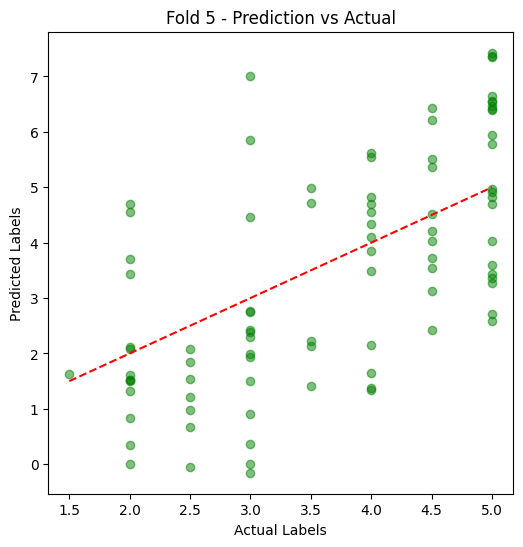

Plotting training curves for Fold 5...


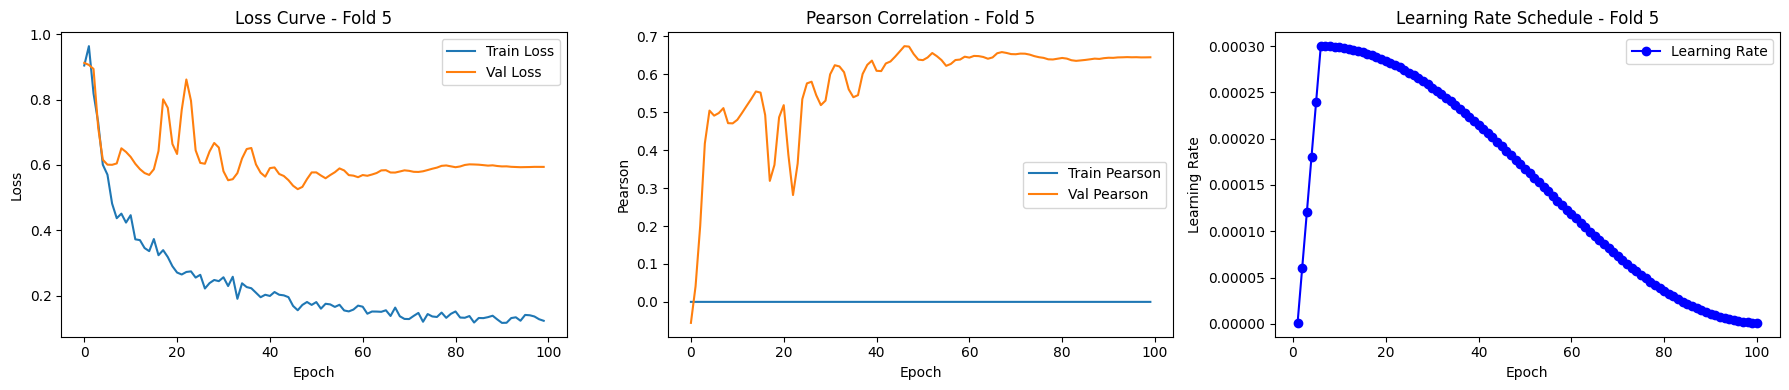

In [16]:
# Define fold number (0-based index)
fold = 4  # Fold 5
print(f"\nStarting Fold {fold+1}/{n_splits}")

# Get training and validation indices for this fold
train_index, val_index = fold_splits[fold]
X_train, X_val = X[train_index], X[val_index]
y_train, y_val = y_standardized[train_index], y_standardized[val_index]

# Create TensorFlow datasets
train_dataset = get_dataset(X_train, y_train, batch_size=64, training=True)
val_dataset = get_dataset(X_val, y_val, batch_size=64, training=False)

# Build and compile model
with strategy.scope():
    model = build_model_variant_v3(input_dim=X.shape[1])
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss=custom_loss(alpha=0.05, beta=0.9, gamma=0.05),
        metrics=[pearson_correlation]
    )
    model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_pearson', patience=20, mode='max', restore_best_weights=True),
    ModelCheckpoint(f"best_model_fold_{fold}.keras", monitor='val_pearson', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_pearson', factor=0.5, patience=8, mode='max', min_lr=1e-6),
    PearsonCallback(X_val, y_val),
    TensorBoard(log_dir=f'./logs_fold_{fold}'),
    LearningRateScheduler(lambda epoch: cosine_annealing(epoch), verbose=1),
]

# Train the model
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=100, 
    callbacks=callbacks, 
    verbose=1
)
histories.append(history)
fold_models.append(model)

# Visualize predictions vs. actual labels
print(f"Visualizing predictions vs. actual labels for Fold {fold+1}...")
val_preds = model.predict(X_val, verbose=0).flatten()
val_preds = (val_preds * y_std) + y_mean
y_val_original = (y_val * y_std) + y_mean
plt.figure(figsize=(6, 6))
plt.scatter(y_val_original, val_preds, alpha=0.5, color='green')
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title(f'Fold {fold+1} - Prediction vs Actual')
plt.savefig(f'pred_vs_actual_fold_{fold+1}.png')
plt.show()

# Plot training curves
print(f"Plotting training curves for Fold {fold+1}...")
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss Curve - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['pearson_correlation'], label='Train Pearson')
plt.plot(history.history['val_pearson'], label='Val Pearson')
plt.title(f"Pearson Correlation - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Pearson')
plt.legend()

num_epochs = len(history.history['loss'])
lr_schedule = [cosine_annealing(epoch) for epoch in range(num_epochs)]
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), lr_schedule, 'bo-', label='Learning Rate')
plt.title(f"Learning Rate Schedule - Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.savefig(f'training_curves_fold_{fold+1}.png')
plt.show()

## Fold 5 Results

### 1. Warmup Phase (Epochs 1-5)
- **Learning Rate**: Starts at `1e-6` (Epoch 1) and increases to `2.402e-4` (Epoch 5), peaking at `3e-4` (Epoch 6).
- **Training Loss**: Falls from `0.8644` (Epoch 1) to `0.6006` (Epoch 5), a 30.5% reduction.
- **Validation Loss**: Decreases from `0.9124` (Epoch 1) to `0.6159` (Epoch 5).
- **Pearson Correlation**: `val_pearson` shifts from `-0.0554` (Epoch 1) to `0.5043` (Epoch 5), a rapid improvement to moderate correlation.
- **Insight**: The warmup phase is highly effective, with `val_pearson` quickly reaching 0.5043, showing the model learns patterns early.

### 2. Peak Learning Rate Phase (Epochs 6-25)
- **Learning Rate**: Peaks at `3e-4` (Epoch 6), then decays to `2.7145e-4` (Epoch 25).
- **Training Loss**: Drops from `0.5369` (Epoch 6) to `0.2709` (Epoch 20), rising slightly to `0.2926` (Epoch 25).
- **Validation Loss**: Fluctuates between `0.6159` (Epoch 5) and `0.6641` (Epoch 20).
- **Pearson Correlation**: `val_pearson` peaks at `0.5043` (Epoch 5), then hovers around `0.47-0.49` (e.g., `0.4706` at Epoch 10, `0.4866` at Epoch 20).
- **Insight**: Performance is inconsistent, with `val_pearson` stagnating and validation loss increasing, suggesting potential overfitting or data challenges.

### 3. Mid-to-Late Epochs (Epochs 26-75)
- **Learning Rate**: Decays from `2.6848e-4` (Epoch 26) to `5.2938e-05` (Epoch 75).
- **Training Loss**: Decreases to `0.1394` (Epoch 75).
- **Validation Loss**: Improves to `0.5362` (Epoch 46), with a minimum of `0.5258` (Epoch 47).
- **Pearson Correlation**: `val_pearson` peaks at `0.6741` (Epoch 47), rising from `0.4866` (Epoch 20) to `0.6602` (Epoch 46).
- **Insight**: The model recovers, achieving its best performance at Epoch 47 (`val_pearson` = 0.6741), indicating it benefits from extended training.

### 4. Final Epochs (Epochs 76-100)
- **Learning Rate**: Drops to `1.0817e-6` (Epoch 100).
- **Training Loss**: Stabilizes around `0.12-0.14`, ending at `0.1285` (Epoch 100).
- **Validation Loss**: Rises slightly to `0.5939` (Epoch 100) from the minimum.
- **Pearson Correlation**: `val_pearson` ends at `0.6448` (Epoch 100), below the peak.
- **Insight**: Performance declines slightly due to the low learning rate, but `val_pearson` remains solid at 0.6448.

#### Final Results for Fold 5
- **Best Validation Pearson**: `0.6741` (Epoch 47)
- **Final Validation Pearson**: `0.6448` (Epoch 100)
- **Best Validation Loss**: `0.5258` (Epoch 47)
- **Final Validation Loss**: `0.5939` (Epoch 100)
- **Final Training Loss**: `0.1285`


In [17]:
# Generate ensemble predictions by averaging across all fold models
print("\nMaking ensemble predictions...")
ensemble_preds = np.zeros(len(X_test))  # Initialize predictions array
for model in fold_models:  # Loop over trained models
    preds = model.predict(X_test, verbose=0)  # Predict on test set
    ensemble_preds += preds.flatten()  # Add predictions to ensemble
ensemble_preds = ensemble_preds / len(fold_models)  # Average predictions
ensemble_preds = (ensemble_preds * y_std) + y_mean  # Inverse standardize predictions

# Create submission DataFrame and save to CSV
submission = pd.DataFrame({'filename': test_ids, 'label': ensemble_preds})
submission.to_csv('submission.csv', index=False)  # Save submission file
print("\nSaved submission to submission.csv")


Making ensemble predictions...

Saved submission to submission.csv


The pipeline is designed for a Grammar Scoring task where audio files are processed to extract rich features. These features are then used to train a deep neural network with specialized attention and residual blocks. The model is optimized using custom loss functions and evaluated using k-fold cross validation, with ensemble predictions generated at the end.
### 1. Data Preprocessing and Feature Extraction

#### **Audio Loading & Augmentation**

- **Loading Audio:**  
  Audio files are read using TensorFlow’s I/O functions. Stereo recordings are converted to mono by averaging channels.

- **Augmentation Techniques:**  
  When augmentation is enabled, several audio augmentations are applied:
  - **Time Stretching & Pitch Shifting:** Utilizes librosa to slightly modify the speed and pitch.
  - **Noise Injection:** Adds low-level random noise.
  - **Gain Adjustment:** Randomly scales the amplitude.
  - **Time Shifting:** Rolls the waveform by a random offset.
  
  These augmentations help improve model robustness.

#### **Feature Extraction**

- **YAMNet Embeddings:**  
  Audio waveforms are passed through a pre-trained YAMNet model to extract embeddings representing high-level audio features. When fine-tuning is enabled, these embeddings can be updated during training.

- **Spectrogram-Based Features:**  
  The pipeline computes the Short-Time Fourier Transform (STFT) of the waveform, followed by conversion to a mel-spectrogram. Statistical features (mean and standard deviation) of the mel-spectrogram are computed.

- **Additional Audio Features:**  
  Features extracted using librosa include:
  - **MFCCs (Mel-frequency Cepstral Coefficients):** Mean and standard deviation.
  - **Chroma Features:** Capturing harmonic content.
  - **Spectral Contrast:** Highlighting differences between spectral peaks and valleys.
  - **Zero Crossing Rate:** An indicator of the noisiness or texture of the signal.
  
  All these features are concatenated into a single combined feature vector.

- **Normalization:**  
  After extraction, features are normalized feature-wise (zero mean, unit variance). Labels are also standardized to aid in regression.

---

### 2. Pipeline Architecture

#### **Model Architecture**

The architecture is split into two branches to handle different parts of the combined feature vector:

- **Branch 1 (YAMNet Embeddings):**
  - **Dense Layers with Swish Activation:** Processes the 1024-dimensional YAMNet embeddings.
  - **Residual Blocks:** Two residual blocks are applied to help in learning deep representations.
  - **Refined Feature Attention:** An attention mechanism refines the extracted features.

- **Branch 2 (Other Audio Features):**
  - Similar processing as Branch 1 but with fewer neurons to handle the additional features (mel-spectrogram statistics, MFCCs, etc.).
  
- **Fusion and Final Layers:**
  - The outputs of both branches are concatenated.
  - The combined features go through additional dense layers, batch normalization, dropout, and further residual blocks.
  - Finally, a single output neuron with linear activation is used for regression.

#### **Custom Components & Loss Functions**

- **Attention Layer:**  
  The custom attention mechanism (RefinedFeatureAttention) enhances the feature representation by learning to weigh features adaptively.

- **Residual Blocks:**  
  These blocks allow the network to effectively train deeper layers by providing skip connections.

- **Loss Function:**  
  A composite loss function is used, combining:
  - **Huber Loss:** For robust error handling.
  - **Pearson Correlation Loss:** To directly optimize the correlation between predictions and true labels.
  - **Ranking Loss:** To ensure proper ordering of predictions relative to ground truth values.
  
  The combination is weighted by predefined coefficients.

---

### 3. Training and Evaluation

- **Cross Validation:**  
  The training data is split into 5 folds using KFold cross-validation to ensure the model generalizes well.

- **Learning Rate Scheduling:**  
  A cosine annealing schedule (with warmup) dynamically adjusts the learning rate during training.

- **Callbacks:**  
  Several callbacks are used:
  - **EarlyStopping:** To prevent overfitting based on validation Pearson correlation.
  - **ModelCheckpoint:** Saves the best model per fold.
  - **ReduceLROnPlateau & LearningRateScheduler:** For dynamic learning rate management.
  - **Custom PearsonCallback:** Prints out the Pearson correlation at the end of each epoch.
  - **TensorBoard:** For logging training metrics.

- **Visualization:**  
  The code includes visualizations for:
  - **Feature Distributions:** Histograms to check normalization.
  - **Prediction vs. Actual Plots:** Scatter plots for each fold.
  - **Training Curves:** Loss, Pearson correlation, and learning rate curves.

- **Ensemble Predictions:**  
  After training all folds, predictions from each fold are averaged to form ensemble predictions, which are then converted back to the original label scale for submission.



---

## Comparison Across All Five Folds


| **Metric**            | **Fold 1**       | **Fold 2**       | **Fold 3**       | **Fold 4**       | **Fold 5**       |
|-----------------------|------------------|------------------|------------------|------------------|------------------|
| **Best val_pearson**  | 0.5687 (Epoch 55) | 0.6466 (Epoch 59) | 0.6948 (Epoch 57) | 0.6951 (Epoch 44) | 0.6741 (Epoch 47) |
| **Final val_pearson** | 0.5625 (Epoch 100) | 0.6435 (Epoch 100) | 0.6868 (Epoch 100) | 0.6807 (Epoch 100) | 0.6448 (Epoch 100) |
| **Best val_loss**     | 0.6398 (Epoch 16) | 0.4551 (Epoch 72) | 0.5622 (Epoch 56) | 0.5530 (Epoch 44) | 0.5258 (Epoch 47) |
| **Final val_loss**    | 0.6569 (Epoch 100) | 0.4646 (Epoch 100) | 0.5628 (Epoch 100) | 0.5547 (Epoch 100) | 0.5939 (Epoch 100) |
| **Final train_loss**  | 0.1599            | 0.1240            | 0.1283            | 0.1260            | 0.1285            |

### Key Observations
- **Performance Variability**: Fold 1 has the weakest performance (`best val_pearson` = 0.5687), while Folds 3 and 4 excel (`0.6948` and `0.6951`). This suggests differences in validation set difficulty or data distribution.
- **Peak Timing**: Peak `val_pearson` occurs between Epochs 44-59 across folds, with Fold 1 peaking earliest (Epoch 55) and Fold 2 latest (Epoch 59).
- **Final vs. Best**: Final `val_pearson` values are slightly lower than peaks in all folds, suggesting minor degradation in the final epochs.

### Average Results Across Folds
- **Average Best val_pearson**: `(0.5687 + 0.6466 + 0.6948 + 0.6951 + 0.6741) / 5 = 0.6559`
- **Average Final val_pearson**: `(0.5625 + 0.6435 + 0.6868 + 0.6807 + 0.6448) / 5 = 0.6437`
- **Average Best val_loss**: `(0.6398 + 0.4551 + 0.5622 + 0.5530 + 0.5258) / 5 = 0.5472`
- **Average Final val_loss**: `(0.6569 + 0.4646 + 0.5628 + 0.5547 + 0.5939) / 5 = 0.5666`
- **Average Final train_loss**: `(0.1599 + 0.1240 + 0.1283 + 0.1260 + 0.1285) / 5 = 0.1333`

---

## Conclusion
- **Overall Performance**: The model achieves an average best `val_pearson` of 0.6559, indicating a moderate to strong correlation, with a final average of 0.6437 showing consistency.
- **Fold Insights**: Folds 3 and 4 perform best, while Fold 1 lags, possibly due to validation set differences.
- **Training Dynamics**: The warmup phase drives rapid gains, and peak performance occurs mid-to-late training, supported by the learning rate schedule.

